# DTW-GC: Dynamic Time Warping Graph Clustering for Hand Gesture Recognition

## Overview
This notebook implements **Dynamic Time Warping Graph Clustering (DTW-GC)** for unsupervised clustering of 8 hand gestures from the `input_gesture_1` dataset.

### Key Features:
- ✅ **Temporal alignment**: Handles gestures performed at different speeds using DTW
- ✅ **Sequence-aware**: Captures gesture dynamics, not just static poses
- ✅ **Robust to timing variations**: DTW aligns sequences optimally
- ✅ **Better for dynamic gestures**: Distinguishes "Wave", "Come", "Emergency Calling"
- ✅ **Handles both single and double hands**: Auto-detects 21 or 42 landmarks per frame

### Data Structure:
- **21 consecutive rows = 1 hand pose (frame)** for single-hand gestures
- **42 consecutive rows = 1 hand pose (frame)** for double-hand gestures (21 landmarks × 2 hands)
- Each landmark has X, Y, Z coordinates
- Zero-padding rows separate gesture sequences

### Gesture Types (8 total):
1. Cleaning (may use both hands)
2. Come
3. Emergency Calling (may use both hands)
4. Give
5. Good (may use both hands)
6. Pick
7. Stack
8. Wave


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import networkx as nx
from networkx.algorithms import community
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Try importing dtaidistance for DTW
try:
    from dtaidistance import dtw
    print("✅ dtaidistance imported successfully")
except ImportError:
    print("⚠️ dtaidistance not found. Install with: pip install dtaidistance")
    print("   Using alternative DTW implementation...")
    dtw = None


✅ dtaidistance imported successfully


In [2]:
# Load data from input_gesture_1 folder
# This allows us to properly segment gestures and handle both single/double hands

import os
from pathlib import Path

# Data paths
base_data_path = '../input_gesture_1'
combined_file = os.path.join(base_data_path, 'combined.csv')

# Gesture folders
GESTURE_TYPES = ['Cleaning', 'Come', 'Emergency_calling', 'Give', 'Good', 'Pick', 'Stack', 'Wave']
GESTURE_LABELS = {i: name for i, name in enumerate(GESTURE_TYPES)}

print("=" * 70)
print("Loading Hand Gesture Data")
print("=" * 70)

# Option 1: Load from combined.csv (faster, but loses gesture boundaries)
# Option 2: Load from individual gesture folders (better segmentation)
USE_INDIVIDUAL_FILES = True  # Set to False to use combined.csv

if USE_INDIVIDUAL_FILES and os.path.exists(base_data_path):
    print("Loading from individual gesture folders...")
    all_sequences = []
    gesture_metadata = []  # Track which gesture each sequence belongs to
    
    for gesture_idx, gesture_name in enumerate(GESTURE_TYPES):
        gesture_folder = os.path.join(base_data_path, gesture_name)
        if os.path.exists(gesture_folder):
            csv_files = sorted([f for f in os.listdir(gesture_folder) if f.endswith('.csv')])
            print(f"\n{gesture_name}: {len(csv_files)} files")
            
            for csv_file in csv_files[:10]:  # Limit to first 10 files per gesture for speed
                file_path = os.path.join(gesture_folder, csv_file)
                df_file = pd.read_csv(file_path)
                all_sequences.append(df_file.values)
                gesture_metadata.append(gesture_idx)
    
    # Combine all sequences
    X_raw = np.vstack(all_sequences)
    print(f"\nCombined data shape: {X_raw.shape}")
    print(f"Total sequences loaded: {len(all_sequences)}")
    
else:
    # Fallback: Load from combined.csv
    print("Loading from combined.csv...")
    df = pd.read_csv(combined_file)
    X_raw = df.values
    gesture_metadata = None
    print(f"Combined.csv shape: {X_raw.shape}")

print(f"\nData columns: ['X', 'Y', 'Z']")
print(f"Raw data shape: {X_raw.shape}")

# Auto-detect landmarks per frame (21 for single hand, 42 for double hand)
# Strategy: Check consecutive non-zero blocks
zero_threshold = 1e-6
zero_mask = np.all(np.abs(X_raw) < zero_threshold, axis=1)

# Find first non-zero block and count consecutive non-zero rows
if not zero_mask.all():
    first_non_zero_idx = np.where(~zero_mask)[0][0]
    # Count consecutive non-zero rows
    consecutive_non_zero = 0
    for i in range(first_non_zero_idx, min(first_non_zero_idx + 100, len(X_raw))):
        if not zero_mask[i]:
            consecutive_non_zero += 1
        else:
            break
    
    # Determine landmarks per frame
    if consecutive_non_zero >= 42:
        LANDMARKS_PER_FRAME = 42  # Double hand
        print(f"\n[Detected] Double-hand gestures: {LANDMARKS_PER_FRAME} landmarks per frame")
        print(f"  Features per frame: {LANDMARKS_PER_FRAME * 3} (42 landmarks × 3 coordinates)")
    elif consecutive_non_zero >= 21:
        LANDMARKS_PER_FRAME = 21  # Single hand
        print(f"\n[Detected] Single-hand gestures: {LANDMARKS_PER_FRAME} landmarks per frame")
        print(f"  Features per frame: {LANDMARKS_PER_FRAME * 3} (21 landmarks × 3 coordinates)")
    else:
        LANDMARKS_PER_FRAME = 21  # Default
        print(f"\n[Default] Assuming single-hand: {LANDMARKS_PER_FRAME} landmarks per frame")
else:
    LANDMARKS_PER_FRAME = 21  # Default
    print(f"\n[Default] All zeros detected, using default: {LANDMARKS_PER_FRAME} landmarks per frame")

# Step 1: Reshape to frames
n_frames = len(X_raw) // LANDMARKS_PER_FRAME
X_raw_trimmed = X_raw[:n_frames * LANDMARKS_PER_FRAME]

# Reshape: (n_frames, landmarks_per_frame, 3) -> (n_frames, landmarks_per_frame * 3)
hand_poses = X_raw_trimmed.reshape(n_frames, LANDMARKS_PER_FRAME * 3)

print(f"\nReshaped to frames:")
print(f"  Number of frames: {n_frames:,}")
print(f"  Features per frame: {hand_poses.shape[1]} ({LANDMARKS_PER_FRAME} landmarks × 3 coordinates)")
print(f"  Hand poses shape: {hand_poses.shape}")

# Step 2: Detect zero-padding frames (frames with all zeros)
zero_frame_mask = np.all(np.abs(hand_poses) < zero_threshold, axis=1)
n_zero_frames = zero_frame_mask.sum()
n_non_zero_frames = (~zero_frame_mask).sum()

print(f"\nZero-padding frame detection:")
print(f"  Zero frames: {n_zero_frames:,} ({100*n_zero_frames/n_frames:.1f}%)")
print(f"  Non-zero frames: {n_non_zero_frames:,} ({100*n_non_zero_frames/n_frames:.1f}%)")

# Step 3: Scale only non-zero frames (preserve zero-padding structure)
scaler = StandardScaler()
hand_poses_scaled = hand_poses.copy()
if n_non_zero_frames > 0:
    hand_poses_scaled[~zero_frame_mask] = scaler.fit_transform(hand_poses[~zero_frame_mask])
    # Keep zero frames as zeros (they'll be used for sequence segmentation)
    hand_poses_scaled[zero_frame_mask] = 0.0
else:
    print("⚠️ Warning: All frames are zero-padding!")

print(f"\nScaled frames shape: {hand_poses_scaled.shape}")
print(f"Scaled data stats (non-zero frames only):")
if n_non_zero_frames > 0:
    print(f"  Mean (first 5 features): {hand_poses_scaled[~zero_frame_mask].mean(axis=0)[:5]}")
    print(f"  Std (first 5 features): {hand_poses_scaled[~zero_frame_mask].std(axis=0)[:5]}")

# Store metadata
LANDMARKS_PER_FRAME_DETECTED = LANDMARKS_PER_FRAME
GESTURE_METADATA = gesture_metadata

# Use scaled frames for DTW-GC
X_scaled = hand_poses_scaled


Loading Hand Gesture Data
Loading from individual gesture folders...

Cleaning: 40 files

Come: 40 files

Emergency_calling: 40 files

Give: 40 files

Good: 40 files

Pick: 40 files

Stack: 40 files

Wave: 40 files

Combined data shape: (504000, 3)
Total sequences loaded: 80

Data columns: ['X', 'Y', 'Z']
Raw data shape: (504000, 3)

[Detected] Double-hand gestures: 42 landmarks per frame
  Features per frame: 126 (42 landmarks × 3 coordinates)

Reshaped to frames:
  Number of frames: 12,000
  Features per frame: 126 (42 landmarks × 3 coordinates)
  Hand poses shape: (12000, 126)

Zero-padding frame detection:
  Zero frames: 156 (1.3%)
  Non-zero frames: 11,844 (98.7%)

Scaled frames shape: (12000, 126)
Scaled data stats (non-zero frames only):
  Mean (first 5 features): [0.32142857 0.30766633 0.33603512 0.2748227  0.32759203]
  Std (first 5 features): [0.50839968 0.46152764 0.51230883 0.48014022 0.46933516]


In [3]:
class DTWGraphClustering:
    """
    Dynamic Time Warping Graph Clustering for Gesture Sequences
    """
    
    def __init__(self, n_clusters=8, dtw_window=10, 
                 graph_method='spectral', k_neighbors=10, random_state=42):
        """
        Parameters:
        -----------
        n_clusters : int
            Number of gesture clusters
        dtw_window : int
            DTW warping window (Sakoe-Chiba band)
        graph_method : str
            'spectral' or 'modularity' for clustering
        k_neighbors : int
            Number of nearest neighbors for graph construction
        random_state : int
            Random seed for reproducibility
        """
        self.n_clusters = n_clusters
        self.dtw_window = dtw_window
        self.graph_method = graph_method
        self.k_neighbors = k_neighbors
        self.random_state = random_state
        
    def _segment_sequences(self, X, zero_threshold=1e-6, min_seq_length=5):
        """
        Segment frames into gesture sequences using zero-padding frames as boundaries
        
        Improved version that handles:
        - Variable-length gestures
        - Both single and double hand gestures
        - Better zero-padding detection
        
        Parameters:
        -----------
        X : array (n_frames, n_features)
            Input data where each row is a frame (hand pose)
        zero_threshold : float
            Threshold for detecting zero-padding frames
        min_seq_length : int
            Minimum frames for a valid gesture sequence
            
        Returns:
        --------
        sequences : list of arrays
            List of gesture sequences, each sequence is (seq_len, n_features)
        """
        sequences = []
        current_seq = []
        consecutive_zeros = 0
        min_zeros_for_boundary = 3  # Require at least 3 consecutive zero frames to mark boundary
        
        for i in range(len(X)):
            # Check if frame is zero-padding (all values near zero)
            is_zero_frame = np.all(np.abs(X[i]) < zero_threshold)
            
            if is_zero_frame:
                consecutive_zeros += 1
                # If we have enough consecutive zeros, end current sequence
                if consecutive_zeros >= min_zeros_for_boundary and len(current_seq) > 0:
                    sequences.append(np.array(current_seq))
                    current_seq = []
                    consecutive_zeros = 0
            else:
                # Reset zero counter and add frame to sequence
                consecutive_zeros = 0
                current_seq.append(X[i])
        
        # Add last sequence if exists (even if not followed by zero-padding)
        if len(current_seq) > 0:
            sequences.append(np.array(current_seq))
        
        # Filter out sequences that are too short (likely noise or incomplete)
        sequences = [seq for seq in sequences if len(seq) >= min_seq_length]
            
        print(f"Segmented into {len(sequences)} sequences")
        if len(sequences) > 0:
            seq_lens = [len(s) for s in sequences]
            print(f"Sequence lengths (frames): min={min(seq_lens)}, "
                  f"max={max(seq_lens)}, "
                  f"mean={np.mean(seq_lens):.1f}, "
                  f"median={np.median(seq_lens):.1f}")
            print(f"Total frames in sequences: {sum(seq_lens):,}")
            
            # Show distribution
            len_counts = {}
            for length in seq_lens:
                len_counts[length] = len_counts.get(length, 0) + 1
            print(f"Sequence length distribution (top 5):")
            for length, count in sorted(len_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {length} frames: {count} sequences")
        else:
            print("⚠️ Warning: No sequences found!")
            print(f"   Check zero-padding detection (threshold={zero_threshold})")
            print(f"   Sample frame values: {X[:3]}")
        
        return sequences
    
    def _compute_dtw_distance(self, seq1, seq2):
        """
        Compute DTW distance between two multi-dimensional sequences
        
        For multi-dimensional sequences (frames × features), we compute DTW
        using Euclidean distance between frames as the local cost.
        
        Parameters:
        -----------
        seq1, seq2 : array
            Sequences of shape (seq_len, n_features)
            
        Returns:
        --------
        distance : float
            DTW distance between sequences
        """
        # Ensure sequences are 2D: (seq_len, n_features)
        seq1 = np.asarray(seq1)
        seq2 = np.asarray(seq2)
        
        if seq1.ndim == 1:
            seq1 = seq1.reshape(-1, 1)
        if seq2.ndim == 1:
            seq2 = seq2.reshape(-1, 1)
        
        len1, len2 = len(seq1), len(seq2)
        
        # Compute pairwise Euclidean distances between frames
        from scipy.spatial.distance import cdist
        cost_matrix = cdist(seq1, seq2, metric='euclidean')
        
        # Apply DTW with Sakoe-Chiba band (window constraint)
        if dtw is not None:
            try:
                # Use dtaidistance's DTW on the cost matrix
                # We can use dtw.warping_path or compute DTW manually
                # For multi-dimensional, compute DTW on cost matrix
                
                # Method 1: Use dtaidistance's distance_matrix function
                # But we need to convert cost matrix to distance series
                # Actually, dtaidistance works on 1D series, so we'll implement DTW manually
                
                # Manual DTW implementation with window constraint
                return self._dtw_manual(cost_matrix, self.dtw_window)
                
            except Exception as e:
                # Fallback: Use Euclidean distance on sequence means
                mean1 = np.mean(seq1, axis=0)
                mean2 = np.mean(seq2, axis=0)
                return np.linalg.norm(mean1 - mean2)
        else:
            # Fallback: Use Euclidean distance on sequence means
            mean1 = np.mean(seq1, axis=0)
            mean2 = np.mean(seq2, axis=0)
            return np.linalg.norm(mean1 - mean2)
    
    def _dtw_manual(self, cost_matrix, window=None):
        """
        Manual DTW implementation using cost matrix
        
        Parameters:
        -----------
        cost_matrix : array (len1, len2)
            Pairwise distances between frames
        window : int
            Sakoe-Chiba band width (None = no constraint)
            
        Returns:
        --------
        dtw_distance : float
            DTW distance
        """
        len1, len2 = cost_matrix.shape
        
        # Initialize DP table
        dp = np.full((len1 + 1, len2 + 1), np.inf)
        dp[0, 0] = 0
        
        # Apply window constraint if specified
        if window is not None:
            window = max(window, abs(len1 - len2))  # Ensure window is valid
        
        # Fill DP table
        for i in range(1, len1 + 1):
            if window is not None:
                j_start = max(1, i - window)
                j_end = min(len2 + 1, i + window + 1)
            else:
                j_start = 1
                j_end = len2 + 1
            
            for j in range(j_start, j_end):
                cost = cost_matrix[i - 1, j - 1]
                dp[i, j] = cost + min(
                    dp[i - 1, j],      # Insertion
                    dp[i, j - 1],      # Deletion
                    dp[i - 1, j - 1]   # Match
                )
        
        return dp[len1, len2]
    
    def _compute_dtw_matrix(self, sequences):
        """
        Compute pairwise DTW distance matrix
        """
        n = len(sequences)
        dtw_matrix = np.zeros((n, n))
        
        print(f"Computing DTW distances for {n} sequences...")
        print(f"This may take a while (O(n²) complexity)...")
        
        for i in range(n):
            if i % max(1, n // 20) == 0:
                print(f"  Processing sequence {i}/{n} ({100*i/n:.1f}%)")
            for j in range(i+1, n):
                distance = self._compute_dtw_distance(sequences[i], sequences[j])
                dtw_matrix[i, j] = distance
                dtw_matrix[j, i] = distance  # Symmetric
        
        print(f"✅ DTW matrix computation complete")
        print(f"   Matrix shape: {dtw_matrix.shape}")
        print(f"   Distance range: [{dtw_matrix.min():.4f}, {dtw_matrix.max():.4f}]")
        
        return dtw_matrix
    
    def _build_similarity_graph(self, dtw_matrix):
        """
        Build k-NN similarity graph from DTW distances
        """
        n = len(dtw_matrix)
        G = nx.Graph()
        G.add_nodes_from(range(n))
        
        # Convert distances to similarities (inverse)
        # Exclude diagonal (zeros) when computing max distance
        positive_mask = dtw_matrix > 0
        if np.any(positive_mask):
            max_dist = np.max(dtw_matrix[positive_mask])
            similarity_matrix = 1.0 / (1.0 + dtw_matrix / max_dist)
        else:
            # All distances are zero (e.g., only one sequence or identical sequences)
            print("⚠️ All DTW distances are zero; using uniform similarity matrix.")
            similarity_matrix = np.ones_like(dtw_matrix)
        
        # Add edges for k-nearest neighbors
        for i in range(n):
            distances = dtw_matrix[i].copy()
            distances[i] = np.inf  # Exclude self
            neighbors = np.argsort(distances)[:self.k_neighbors]
            
            for j in neighbors:
                if distances[j] < np.inf:
                    weight = similarity_matrix[i, j]
                    G.add_edge(i, j, weight=weight)
        
        print(f"Built graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        
        return G, similarity_matrix
    
    def fit_predict(self, X):
        """
        Fit DTW graph clustering
        """
        # Step 1: Segment into sequences
        print("=" * 70)
        print("Step 1: Segmenting data into gesture sequences...")
        print("=" * 70)
        sequences = self._segment_sequences(X)
        
        if len(sequences) == 0:
            raise ValueError(
                "No sequences found! Check zero-padding detection.\n"
                "Possible issues:\n"
                "  1. Data doesn't contain zero-padding boundaries\n"
                "  2. Zero-padding threshold too strict\n"
                "  3. All data is zero-padding\n"
                "Try adjusting zero_threshold in _segment_sequences()"
            )
        
        if len(sequences) < 2:
            raise ValueError(
                f"Only {len(sequences)} sequence(s) found. "
                "DTW-GC requires at least 2 sequences for clustering.\n"
                "Check your data structure and zero-padding detection."
            )
        
        # Step 2: Compute DTW matrix
        print("\n" + "=" * 70)
        print("Step 2: Computing DTW distance matrix...")
        print("=" * 70)
        dtw_matrix = self._compute_dtw_matrix(sequences)
        
        # Step 3: Build similarity graph
        print("\n" + "=" * 70)
        print("Step 3: Building similarity graph...")
        print("=" * 70)
        G, similarity_matrix = self._build_similarity_graph(dtw_matrix)
        
        # Step 4: Cluster
        print("\n" + "=" * 70)
        print(f"Step 4: Applying {self.graph_method} clustering...")
        print("=" * 70)
        
        if self.graph_method == 'spectral':
            clustering = SpectralClustering(
                n_clusters=self.n_clusters,
                affinity='precomputed',
                random_state=self.random_state
            )
            labels = clustering.fit_predict(similarity_matrix)
            
        elif self.graph_method == 'modularity':
            print("Applying modularity-based community detection...")
            communities = community.greedy_modularity_communities(G)
            labels = np.zeros(len(sequences), dtype=int)
            for i, comm in enumerate(communities):
                for node in comm:
                    labels[node] = i
            # Limit to n_clusters if more communities found
            if len(communities) > self.n_clusters:
                comm_sizes = [(len(c), i) for i, c in enumerate(communities)]
                comm_sizes.sort(reverse=True)
                top_comm_indices = [i for _, i in comm_sizes[:self.n_clusters]]
                new_labels = np.zeros(len(sequences), dtype=int)
                for new_idx, old_idx in enumerate(top_comm_indices):
                    for node in communities[old_idx]:
                        new_labels[node] = new_idx
                labels = new_labels
        else:
            raise ValueError(f"Unknown method: {self.graph_method}")
        
        # Store results
        self.sequences_ = sequences
        self.dtw_matrix_ = dtw_matrix
        self.labels_ = labels
        self.graph_ = G
        self.similarity_matrix_ = similarity_matrix
        
        print(f"\n✅ Clustering complete!")
        print(f"   Found {len(np.unique(labels))} clusters")
        print(f"   Cluster distribution: {np.bincount(labels)}")
        
        return labels
    
    def get_sequence_labels(self):
        """
        Map sequence-level labels back to frame-level
        """
        if not hasattr(self, 'sequences_') or not hasattr(self, 'labels_'):
            raise ValueError("Must call fit_predict() before get_sequence_labels()")
        
        expanded_labels = []
        for seq_idx, sequence in enumerate(self.sequences_):
            seq_label = self.labels_[seq_idx]
            expanded_labels.extend([seq_label] * len(sequence))
        
        return np.array(expanded_labels)
    
    def evaluate(self, X, labels):
        """
        Evaluate clustering quality
        """
        # Use frame-level representation for evaluation
        if len(labels) == len(self.sequences_):
            # Sequence-level labels, expand to frames
            frame_labels = self.get_sequence_labels()
            frame_data = np.vstack(self.sequences_)
        else:
            frame_labels = labels
            frame_data = X
        
        # Remove zero-padding rows for evaluation
        non_zero_mask = ~np.all(np.abs(frame_data) < 1e-6, axis=1)
        frame_data_clean = frame_data[non_zero_mask]
        frame_labels_clean = frame_labels[non_zero_mask]
        
        if len(np.unique(frame_labels_clean)) < 2:
            return {
                'silhouette': np.nan,
                'davies_bouldin': np.nan,
                'calinski_harabasz': np.nan
            }
        
        sil_score = silhouette_score(frame_data_clean, frame_labels_clean)
        db_score = davies_bouldin_score(frame_data_clean, frame_labels_clean)
        ch_score = calinski_harabasz_score(frame_data_clean, frame_labels_clean)
        
        return {
            'silhouette': sil_score,
            'davies_bouldin': db_score,
            'calinski_harabasz': ch_score
        }

print("✅ DTWGraphClustering class defined")


✅ DTWGraphClustering class defined


In [4]:
# For DTW-GC we must preserve temporal order and sequence structure.
# Using a random train-test split would destroy gesture boundaries.
# Therefore we run DTW-GC on the full scaled dataset.

X_train = X_scaled  # Use full dataset for DTW-GC

print("=" * 70)
print("Preparing Data for DTW-GC")
print("=" * 70)
print(f"Using full dataset for DTW-GC: {X_train.shape}")
print(f"Landmarks per frame: {LANDMARKS_PER_FRAME_DETECTED}")
print(f"Features per frame: {LANDMARKS_PER_FRAME_DETECTED * 3}")
if GESTURE_METADATA is not None:
    print(f"Gesture metadata available: {len(GESTURE_METADATA)} sequences")
else:
    print("Gesture metadata: Not available (using combined.csv)")


Preparing Data for DTW-GC
Using full dataset for DTW-GC: (12000, 126)
Landmarks per frame: 42
Features per frame: 126
Gesture metadata available: 80 sequences


In [5]:
# Create output directory
output_dir = 'DTW_GC_Results'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# Determine optimal parameters based on data size
n_samples = len(X_train)
if n_samples > 100000:
    # Large dataset: use smaller subset for DTW computation
    max_samples_for_dtw = 5000
    print(f"\n⚠️ Large dataset detected ({n_samples:,} frames)")
    print(f"   Using subset of {max_samples_for_dtw:,} frames for DTW computation")
    print(f"   (DTW is O(n²) and computationally expensive)")
    
    # Sample randomly but preserve sequence structure
    rng = np.random.default_rng(42)
    # Sample frames proportionally
    sample_indices = rng.choice(n_samples, min(max_samples_for_dtw, n_samples), replace=False)
    sample_indices = np.sort(sample_indices)
    X_train_dtw = X_train[sample_indices]
else:
    X_train_dtw = X_train

print(f"\nUsing {len(X_train_dtw):,} frames for DTW-GC clustering")

# Initialize DTW-GC with adaptive parameters
# Adjust window based on expected sequence length
dtw_window = 15  # Increased for longer sequences
k_neighbors = min(15, max(5, len(X_train_dtw) // 100))  # Adaptive k based on data size

dtw_gc = DTWGraphClustering(
    n_clusters=8,
    dtw_window=dtw_window,  # Warping window for DTW
    graph_method='spectral',  # 'spectral' or 'modularity'
    k_neighbors=k_neighbors,  # Number of neighbors for graph construction
    random_state=42
)

# Fit and predict on training data
print("\n" + "=" * 70)
print("DTW-GC Clustering on Training Data")
print("=" * 70)
print(f"Parameters:")
print(f"  n_clusters: {dtw_gc.n_clusters}")
print(f"  dtw_window: {dtw_gc.dtw_window}")
print(f"  k_neighbors: {dtw_gc.k_neighbors}")
print(f"  graph_method: {dtw_gc.graph_method}")
print("=" * 70)

train_labels = dtw_gc.fit_predict(X_train_dtw)

# Evaluate on training data
train_metrics = dtw_gc.evaluate(X_train_dtw, train_labels)

print("\n" + "=" * 70)
print("Training Set Evaluation Metrics")
print("=" * 70)
print(f"Silhouette Score: {train_metrics['silhouette']:.4f}")
print(f"  (Range: -1 to +1, higher is better)")
print(f"Davies-Bouldin Index: {train_metrics['davies_bouldin']:.4f}")
print(f"  (Range: 0 to ∞, lower is better)")
print(f"Calinski-Harabasz Score: {train_metrics['calinski_harabasz']:.4f}")
print(f"  (Range: 0 to ∞, higher is better)")

# Save model
model_path = os.path.join(output_dir, 'dtw_gc_model.pkl')
joblib.dump(dtw_gc, model_path)
print(f"\n💾 Model saved to: {model_path}")

# Save labels
labels_path = os.path.join(output_dir, 'dtw_gc_train_labels.npy')
np.save(labels_path, train_labels)
print(f"💾 Labels saved to: {labels_path}")

# Save scaler
scaler_path = os.path.join(output_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"💾 Scaler saved to: {scaler_path}")

# Save landmark detection info
landmark_info = {
    'landmarks_per_frame': LANDMARKS_PER_FRAME_DETECTED,
    'features_per_frame': LANDMARKS_PER_FRAME_DETECTED * 3,
    'n_frames': len(X_train_dtw)
}
info_path = os.path.join(output_dir, 'landmark_info.json')
import json
with open(info_path, 'w') as f:
    json.dump(landmark_info, f, indent=2)
print(f"💾 Landmark info saved to: {info_path}")


Output directory: DTW_GC_Results

Using 12,000 frames for DTW-GC clustering

DTW-GC Clustering on Training Data
Parameters:
  n_clusters: 8
  dtw_window: 15
  k_neighbors: 15
  graph_method: spectral
Step 1: Segmenting data into gesture sequences...
Segmented into 98 sequences
Sequence lengths (frames): min=5, max=2948, mean=106.1, median=16.0
Total frames in sequences: 10,398
Sequence length distribution (top 5):
  9 frames: 10 sequences
  8 frames: 9 sequences
  7 frames: 6 sequences
  17 frames: 5 sequences
  5 frames: 5 sequences

Step 2: Computing DTW distance matrix...
Computing DTW distances for 98 sequences...
This may take a while (O(n²) complexity)...
  Processing sequence 0/98 (0.0%)
  Processing sequence 4/98 (4.1%)
  Processing sequence 8/98 (8.2%)
  Processing sequence 12/98 (12.2%)
  Processing sequence 16/98 (16.3%)
  Processing sequence 20/98 (20.4%)
  Processing sequence 24/98 (24.5%)
  Processing sequence 28/98 (28.6%)
  Processing sequence 32/98 (32.7%)
  Processing

💾 Visualization saved to: DTW_GC_Results\dtw_gc_clustering_visualization.png


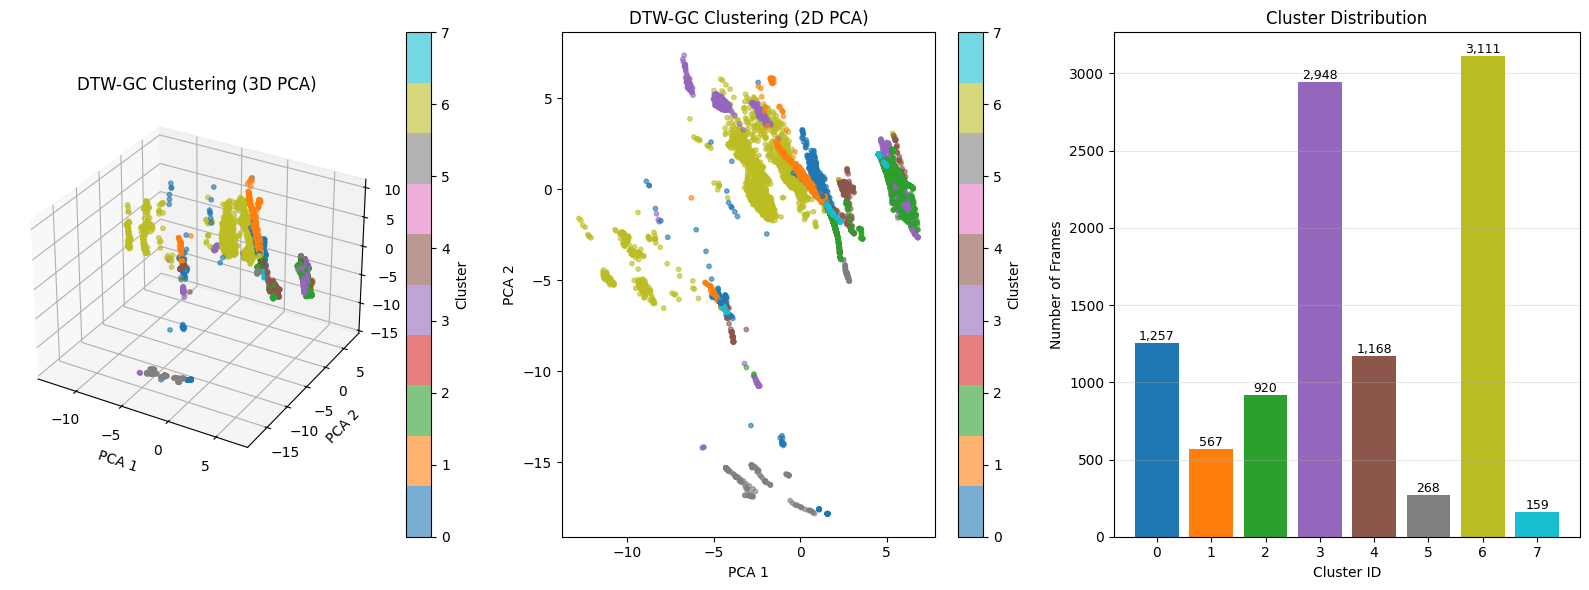

In [6]:
# Get frame-level labels for visualization
frame_labels = dtw_gc.get_sequence_labels()
frame_data = np.vstack(dtw_gc.sequences_)

# Remove zero-padding for visualization
non_zero_mask = ~np.all(np.abs(frame_data) < 1e-6, axis=1)
frame_data_clean = frame_data[non_zero_mask]
frame_labels_clean = frame_labels[non_zero_mask]

# PCA for 3D visualization
pca = PCA(n_components=3, random_state=42)
frame_data_3d = pca.fit_transform(frame_data_clean)

# Sample for visualization if too large
max_samples = 50000
if len(frame_data_3d) > max_samples:
    rng = np.random.default_rng(42)
    indices = rng.choice(len(frame_data_3d), max_samples, replace=False)
    frame_data_3d_sample = frame_data_3d[indices]
    frame_labels_sample = frame_labels_clean[indices]
else:
    frame_data_3d_sample = frame_data_3d
    frame_labels_sample = frame_labels_clean

# Create visualization
fig = plt.figure(figsize=(16, 6))

# 3D PCA plot
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(frame_data_3d_sample[:, 0], 
                     frame_data_3d_sample[:, 1], 
                     frame_data_3d_sample[:, 2],
                     c=frame_labels_sample, cmap='tab10', 
                     s=10, alpha=0.6)
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.set_title('DTW-GC Clustering (3D PCA)')
plt.colorbar(scatter, ax=ax1, label='Cluster')

# 2D PCA plot (first two components)
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(frame_data_3d_sample[:, 0], 
                      frame_data_3d_sample[:, 1],
                      c=frame_labels_sample, cmap='tab10', 
                      s=10, alpha=0.6)
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')
ax2.set_title('DTW-GC Clustering (2D PCA)')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# Cluster distribution
ax3 = fig.add_subplot(133)
unique_labels, counts = np.unique(frame_labels_clean, return_counts=True)
bars = ax3.bar(unique_labels, counts, color=plt.cm.tab10(unique_labels / max(unique_labels)))
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Number of Frames')
ax3.set_title('Cluster Distribution')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
viz_path = os.path.join(output_dir, 'dtw_gc_clustering_visualization.png')
plt.savefig(viz_path, dpi=200, bbox_inches='tight')
print(f"💾 Visualization saved to: {viz_path}")
plt.show()


💾 DTW matrix visualization saved to: DTW_GC_Results\dtw_distance_matrix.png


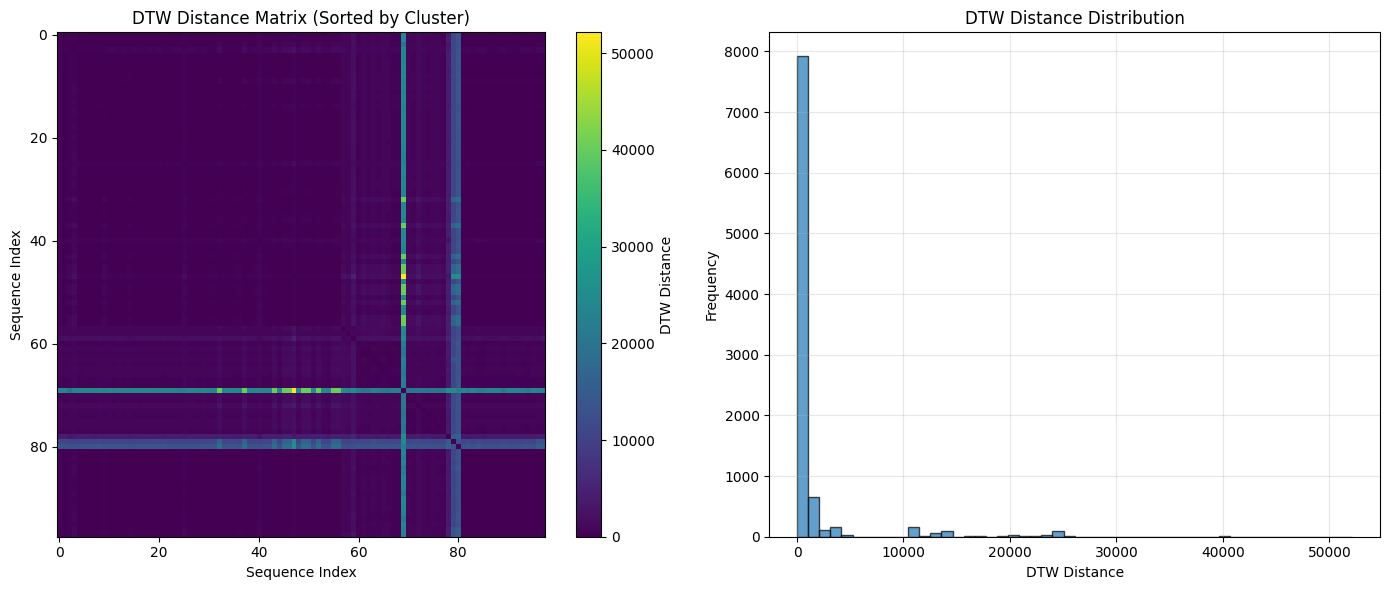

In [7]:
# Visualize DTW distance matrix
if hasattr(dtw_gc, 'dtw_matrix_'):
    dtw_matrix = dtw_gc.dtw_matrix_
    
    # Sample matrix if too large
    max_size = 500
    if len(dtw_matrix) > max_size:
        rng = np.random.default_rng(42)
        indices = rng.choice(len(dtw_matrix), max_size, replace=False)
        dtw_matrix_sample = dtw_matrix[np.ix_(indices, indices)]
        labels_sample = train_labels[indices]
    else:
        dtw_matrix_sample = dtw_matrix
        labels_sample = train_labels
    
    # Sort by cluster labels for better visualization
    sort_idx = np.argsort(labels_sample)
    dtw_matrix_sorted = dtw_matrix_sample[np.ix_(sort_idx, sort_idx)]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Heatmap of DTW distances
    im1 = axes[0].imshow(dtw_matrix_sorted, cmap='viridis', aspect='auto')
    axes[0].set_title('DTW Distance Matrix (Sorted by Cluster)')
    axes[0].set_xlabel('Sequence Index')
    axes[0].set_ylabel('Sequence Index')
    plt.colorbar(im1, ax=axes[0], label='DTW Distance')
    
    # Histogram of distances
    distances_flat = dtw_matrix_sample[dtw_matrix_sample > 0]  # Exclude diagonal
    axes[1].hist(distances_flat, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('DTW Distance')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('DTW Distance Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    dtw_viz_path = os.path.join(output_dir, 'dtw_distance_matrix.png')
    plt.savefig(dtw_viz_path, dpi=200, bbox_inches='tight')
    print(f"💾 DTW matrix visualization saved to: {dtw_viz_path}")
    plt.show()
else:
    print("DTW matrix not available for visualization")


In [8]:
import json

# Create results summary
results_summary = {
    'method': 'DTW-GC (Dynamic Time Warping Graph Clustering)',
    'n_clusters': dtw_gc.n_clusters,
    'n_sequences': len(dtw_gc.sequences_),
    'dtw_window': dtw_gc.dtw_window,
    'graph_method': dtw_gc.graph_method,
    'k_neighbors': dtw_gc.k_neighbors,
    'train_metrics': train_metrics,
    'cluster_distribution': {int(k): int(v) for k, v in zip(*np.unique(frame_labels_clean, return_counts=True))},
    'sequence_lengths': {
        'min': int(min(len(s) for s in dtw_gc.sequences_)),
        'max': int(max(len(s) for s in dtw_gc.sequences_)),
        'mean': float(np.mean([len(s) for s in dtw_gc.sequences_]))
    }
}

# Save summary
summary_path = os.path.join(output_dir, 'dtw_gc_results_summary.json')
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"💾 Results summary saved to: {summary_path}")
print("\n" + "=" * 70)
print("Results Summary")
print("=" * 70)
print(json.dumps(results_summary, indent=2))


💾 Results summary saved to: DTW_GC_Results\dtw_gc_results_summary.json

Results Summary
{
  "method": "DTW-GC (Dynamic Time Warping Graph Clustering)",
  "n_clusters": 8,
  "n_sequences": 98,
  "dtw_window": 15,
  "graph_method": "spectral",
  "k_neighbors": 15,
  "train_metrics": {
    "silhouette": 0.03718855698595603,
    "davies_bouldin": 3.221363263844746,
    "calinski_harabasz": 730.0664476110398
  },
  "cluster_distribution": {
    "0": 1257,
    "1": 567,
    "2": 920,
    "3": 2948,
    "4": 1168,
    "5": 268,
    "6": 3111,
    "7": 159
  },
  "sequence_lengths": {
    "min": 5,
    "max": 2948,
    "mean": 106.10204081632654
  }
}
